# Homework 4


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import os.path
from os.path import exists
import os

from sklearn.decomposition import PCA

import time
import numpy as np
import h5py
import urllib.request

device="cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    device="cuda:0"
print(device)    

cpu


## Problem 1 (40 points): Revisiting our CNN

Let's revisit the CNN notebook that we worked through in class, and modify the code there to do something slightly different.

First, let's import our data:

In [2]:
output = 'ising_data.npz'

if not exists(output):
    import gdown
    url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
    gdown.download(url, output, quiet=True)

f = np.load(output, allow_pickle=True)
n_train = 20000
n_test=len(f["C"])-n_train

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
y_train, y_test = f["T"][:n_train], f["T"][n_train:]

x_train_tensor=torch.tensor(x_train,dtype=torch.float).unsqueeze(1)
y_train_tensor=torch.tensor(y_train,dtype=torch.float).unsqueeze(1)

x_test_tensor=torch.tensor(x_test,dtype=torch.float).unsqueeze(1)
y_test_tensor=torch.tensor(y_test,dtype=torch.float).unsqueeze(1)

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)

torch.manual_seed(123)

In the CNN lecture notebook, we used a CNN to predict whether the image had crossed the phase transition boundary or not.  What I'd like to do is a followup that I may have mentioned in lecture: let's use the CNN to predict the temperature that corresponds to the image, instead of a binary "yes/no" decision.  Some things to consider:

* What should the loss function be?

**Now your job**: setup and train a CNN that predicts the temperature associated with each image.  Here are some requirements, which may be different from what was done in the CNN notebook in class:

* Have the first convolutional layer use 16 filters
* Have the second convolutional layer use 32 filters
* Have the fully-connected part at the end include two layers with 32 nodes
* Use the `Adam` optimizer with a learning rate of 0.01
* Run for 10 epochs


As part of this problem, you should produce:
* The normal loss plot showing the training and test losses vs the number of epochs
* Once the network is trained, pass the test data through the network again, and get the predicted values.  Compare the predicted values with the true values; plot the difference and find the bias and variance of the network.

Some hints:
* You don't necessarily need to run the code for the full 16+32 convolutional filter network every time, the training takes a little while!  Feel free to debug with smaller numbers of filters.
* However, the setup is a bit delicate, so even small changes in the hyperparameters specified above may cause the training to not converge.

In [3]:
# your code defining the AutoEncoder class goes here
torch.manual_seed(123)
class Net(torch.nn.Module):
    def __init__(self, conv_layer_size=16, linear_layer_size=32):
        super(Net, self).__init__()

        lls=linear_layer_size
        cls=conv_layer_size
        
        # two convolutional layers
        self.conv1 = torch.nn.Conv2d(  1, cls, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(cls, lls, kernel_size=3, padding=1)

        # fully connected layer
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(lls, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,1))

    # x represents our data
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        # if we wanted to add another layer before pooling, we could do that here.

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        
        # we could also do some dropout here if we wanted

        x = self.conv2(x)
        x = F.relu(x)

        # perhaps we want another layer here?

        # the (1,1) makes this into global average pooling
        x = F.adaptive_avg_pool2d(x,(1,1))
    
        # Flatten x with start_dim=1, i.e. only keep one number per channel per event.
        # This one line kept me up into the wee hours the other night!
        x=torch.flatten(x,1)
      
        # Pass data through the fully connected layer.
        x = self.fc1(x)

        return x

In [4]:
# create the net, define the loss fuction and optimizer
net = Net()
print(net)
print(np.sum([np.prod(theta.shape) for theta in net.parameters()]))

#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
6945


In [5]:
# train the net
losses = []
losses_test = []

loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(x_train)/5), shuffle=True)

for epoch in range(10):
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in 19.8s, Train loss=6.7e-01, Test loss=7.6e-01
Completed epoch  1 in 16.5s, Train loss=3.3e-01, Test loss=4.9e-01
Completed epoch  2 in 14.8s, Train loss=7.2e-02, Test loss=1.9e-01
Completed epoch  3 in 13.4s, Train loss=4.4e-02, Test loss=8.4e-02
Completed epoch  4 in 13.2s, Train loss=6.7e-02, Test loss=5.0e-02
Completed epoch  5 in 13.2s, Train loss=5.7e-02, Test loss=3.9e-02
Completed epoch  6 in 16.9s, Train loss=6.4e-02, Test loss=4.9e-02
Completed epoch  7 in 17.3s, Train loss=5.5e-02, Test loss=4.5e-02
Completed epoch  8 in 16.1s, Train loss=4.6e-02, Test loss=4.4e-02
Completed epoch  9 in 18.9s, Train loss=4.5e-02, Test loss=4.2e-02


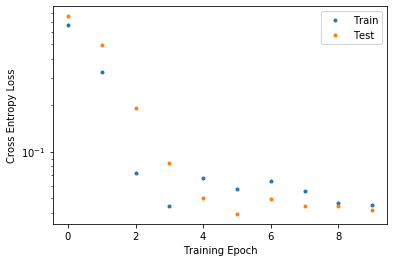

In [6]:
# plot the losses
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

In [7]:
# evaluate and plot the losses for individual training dataset events
y_pred = net(x_test_tensor)
y_pred = y_pred.detach().numpy() #in ndarray
y_test = y_test.reshape(6000,1) #adjust so y_pred.shape==y_test.shape
diff = y_pred-y_test

Text(0.5, 1.0, 'Bias:0.05, Variance:0.04')

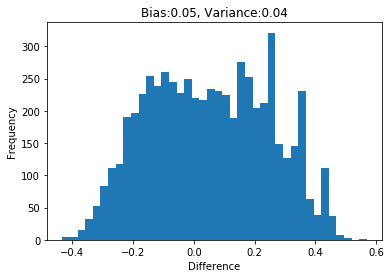

In [8]:
plt.hist(diff,bins=40) #plot difference
bias = np.sum(diff)/len(diff) #bias
variance = np.var(diff) #variance
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.title("Bias:{}, Variance:{}".format(round(bias,2),round(variance,2)))

In [9]:
# evaluate and plot the losses for individual training dataset events

## Problem 2 (20 points): Principal Components Analysis

Let's perform a PCA test on some input data that we'll use for Problem #3.

First let's get some training and test datasets that we can use...  we'll start with one of the files that we used from HW3:

In [10]:
def clean_sample(sample):
    events=[]
    for i in sample:
        if i[0]>2:
            events.append(i)
    return events

def get_sample_from_URL(samplename,branches):
    
    if not os.path.isfile(samplename):
        urllib.request.urlretrieve("http://mhance.scipp.ucsc.edu/%s" % samplename, samplename)

    alldata=None
    with h5py.File(samplename,'r') as hdf5file:
        data=hdf5file[list(hdf5file.keys())[0]]["lowleveltree"]
        num_backgr_events=len(data["numjet"])
        alldata = data[branches]    

    Alldata=[[float(i) for i in j] for j in alldata]
    Alldata_clean=clean_sample(Alldata)
    return Alldata_clean

In [11]:
# now scale based on the training data:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

branches=("numjet","numlepton","numbtagjet",
          "met","metphi",
          "jet1pT", "jet1eta", "jet1phi","jet1b",
          "jet2pT", "jet2eta", "jet2phi","jet2b",
          "jet3pT", "jet3eta", "jet3phi","jet3b")

traindata=get_sample_from_URL('lowlevelAna_ttbar.hf5',branches)
x_train = sc.fit_transform(traindata)
train=torch.tensor(x_train,dtype=torch.float)

testdata=get_sample_from_URL('lowlevelAna_test.hf5',branches)
x_test = sc.transform(testdata)
test=torch.tensor(x_test,dtype=torch.float)

Using the `scikit-learn` PCA tool, analyze the `ttbar` dataset (`x_train`) retrieved above.

* Find the number of components needed to explain 50% of the variance.
* List the magnitudes of that number of leading eigenvalues, as a fraction of the total variance they capture

(9520, 17)
(9520, 2)
# of components need to explain 50 % of the variance: 5
Magnitude of leading eigenvalues as a fraction of the total variance they capture: [0.15115807 0.10300033 0.0937513  0.08374712 0.08169285]


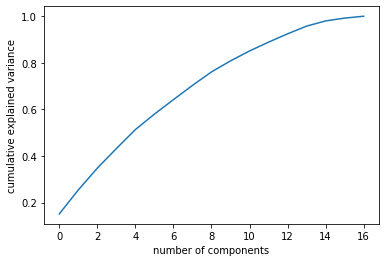

In [12]:
# your code here
from sklearn.decomposition import PCA

print(x_train.data.shape) #Get dimension of training data

pca = PCA(2) #From 17 to 2 dimensions
projected = pca.fit_transform(x_train.data)
print(projected.shape)

pca = PCA().fit(x_train.data) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Below_Half = np.cumsum(pca.explained_variance_ratio_) <= 0.55 #Boolean of all values with eigenvalue < 0.55 
N_of_CompHalf = np.arange(len(np.cumsum(pca.explained_variance_ratio_)))[Below_Half] #Determine # of components
print("# of components need to explain 50 % of the variance: {}".format(max(N_of_CompHalf)+1)) #+1 b/c Python count from 0

Eigenvalue_Ratios = pca.explained_variance_ratio_ #Eigenvalue ratios
print("Magnitude of leading eigenvalues as a fraction of the total variance they capture: {}".format(Eigenvalue_Ratios[Below_Half]))

## Problem 3 (40 points): AutoEncoders for Anomaly Detection

We discussed the use of AutoEncoders for de-noising, let's also look at AutoEncoders in the context of anomaly detection.  The goal will be to use an AutoEncoder to find "anomalies" in a data sample without knowing what those anomalies are.  We'll do this by training the network on an un-labeled data sample (i.e. unsupervised learning) and then using the trained network to evaluate a test dataset that has anomalies included.  The anomalies should show up as events with large loss values.

For this problem, we'll use the `ttbar` dataset from problem 2 for training, and the `testdata` dataset from problem 2 for testing.

**Your job**: Define our AutoEncoder, following the scheme we used in the AutoEncoder notebook in class, with the following changes:

* The number of input variables should be the number of variables needed to explain 50% of the variance in the `ttbar` sample (see solutions to Problem 2, let's call this number N_50).
* Use the `LeakyReLU` activation function, with args = `(0.2,inplace-True)`
* The encoder should have three layers:  (1) the input layer, with N nodes; (2) a hidden layer with 2\*N nodes; (3) a hidden layer with 10 nodes; (4) the latent-space layer, with N_50 nodes.
* Make sure to not define an activation on the last layer!



In [13]:
# your code here
class Autoencoder(torch.nn.Module):

    def __init__(self, N_50):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Sequential(
            torch.nn.Linear(N_50, 2*N_50),
            torch.nn.LeakyReLU(0.2,inplace=True),
            torch.nn.Linear(2*N_50,10),
            torch.nn.LeakyReLU(0.2,inplace=True),
            torch.nn.Linear(10,N_50),
        )
            
        ### DECODER
        self.linear_2 = torch.nn.Linear(N_50,5)
        
    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)
        
        return decoded

Now train the autoencoder on the training data.  Run for 1500 epochs, using the `Adam`optimizer with a learning rate of 0.01.  Afterwards:
* Make a plot of the loss function vs epochs for the training data
* Make a plot of the loss *values* for all events in the training dataset.  This means passing single events into the loss function, instead of entire tensors!
* Now put the net into evaluation mode, and pass the test dataset through the network.  Make the same plot of loss values for all events in the test dataset.  
* Make a single plot that includes both histograms: the training set, and the testing set.

The difference between the training data and the test data can be subtle unless you overlay them, and (hopefully) see that there are more events in the large-loss tail of the test distribution than the training distribution!

In [14]:
device="cpu"
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    device="cuda:0"
print(device)    

# Hyperparameters
random_seed = 123
learning_rate = 0.01
num_epochs = 1500

# Architecture
N_50 = 5

torch.manual_seed(random_seed)
model = Autoencoder(N_50=N_50)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

cpu


In [15]:
losses_train = [] #List to store losses
for epoch in range(num_epochs):
    start_time = time.time()
    
    train = train.view(-1,5) #Reshape training data into: n x 5
    decoded = model(train) #Feed training data into model 
    loss = F.mse_loss(decoded, train) #Calculate loss
    optimizer.zero_grad() #Reset grad

    loss.backward() #Calculate new grad

    ### UPDATE MODEL PARAMETERS
    optimizer.step() #Step forward based on grad

    end_time=time.time()
    elapsed_time = end_time - start_time
    #print("Completed epoch %2d in %4.1fs, Train loss=%4.1e" % (epoch, elapsed_time, loss.data)) 
    
    losses_train.append(loss) #Append losses

Text(0.5, 1.0, 'Losses vs Epoch')

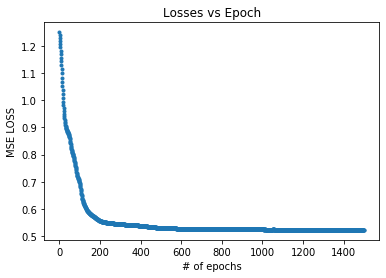

In [16]:
# plot the losses vs epoch
plt.plot(losses_train,".")
plt.xlabel("# of epochs")
plt.ylabel("MSE LOSS")
plt.title("Losses vs Epoch")

A helper function to retrieve the individual event-wise losses from the sample (`getLosses`) 

In [17]:
net.eval()
def getLosses(sample):
    losses=[]
    for i in range(len(sample)):
        pred = net(sample[i])
        loss = loss_fn(pred, sample[i])
        losses.append(loss.data.item())
    return losses

In [18]:
model.eval()
def getLosses_Edit(sample): #Editted to match name of AutoEncoder class and loss function used
    losses=[]
    for i in range(len(sample)):
        pred = model(sample[i])
        loss = F.mse_loss(pred, sample[i])
        losses.append(loss.data.item())
    return losses

Text(0.5, 1.0, 'Distribution of Losses of Single Event')

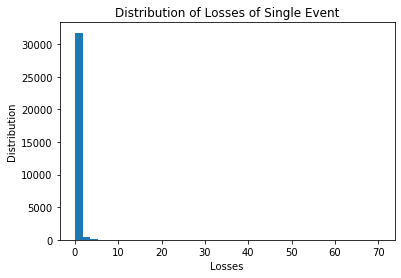

In [19]:
# get the training dataset losses and plot them
SinEventLosses_Train = getLosses_Edit(train)
plt.hist(SinEventLosses_Train,bins=40)
plt.xlabel("Losses")
plt.ylabel("Distribution")
plt.title("Distribution of Losses of Single Event")

Text(0.5, 1.0, 'Distribution of Losses of Single Event')

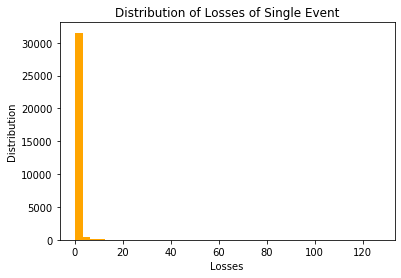

In [20]:
# get the test dataset losses and plot them
test = test.view(-1,5) #Reshape test into: n x 5
SinEventLosses_Test = getLosses_Edit(test)
plt.hist(SinEventLosses_Test,bins=40,color='orange')
plt.xlabel("Losses")
plt.ylabel("Distribution")
plt.title("Distribution of Losses of Single Event")

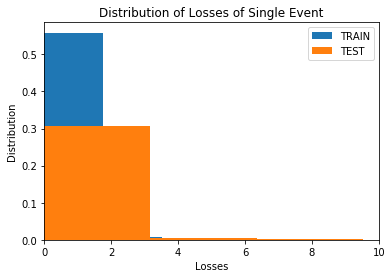

In [21]:
# make a single plot overlaying the training and test dataset losses, 
# with each normalized so they both have unit area.
plt.figure()
plt.hist(SinEventLosses_Train,bins=40,density=True,label="TRAIN")
plt.hist(SinEventLosses_Test,bins=40,density=True,label="TEST")
plt.xlim(0,10)
plt.xlabel("Losses")
plt.ylabel("Distribution")
plt.title("Distribution of Losses of Single Event")
plt.legend()